In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import random
import math
import matplotlib.pyplot as plt
import cvxopt
from sklearn.metrics import confusion_matrix, classification_report, precision_score

In [5]:
df = pd.read_csv('CPZ_data_mini.csv')

df.sort_values(by=['permno','Date'], inplace= True)
df['ret_future'] = df.groupby('permno')['ret'].shift(-1)

In [6]:
y = df['ret']
x = df.drop(columns = ['Date', 'permno', 'ret'])

In [7]:
x -= x.mean()
x /= x.std()

In [8]:
import sklearn.model_selection as sk

x_train, x_test, y_train, y_test = sk.train_test_split(x, y,test_size=0.3, random_state = 42)

x_train, x_val, y_train, y_val = sk.train_test_split(x_train, y_train, test_size=0.3, random_state = 42)

In [9]:
x_train.shape, x_val.shape, x_test.shape

((597091, 19), (255897, 19), (365567, 19))

In [425]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_normal

In [424]:
def train_nn(X, y, X_vali, y_vali, alpha, epochs=20, num_layers = 3, num_neurons = [16,8,1], lamda=0.0001,p=0.1):
    model = Sequential()
    model.add(Dense(num_neurons[0], activation='relu',
                        kernel_regularizer=l2(lamda), 
                        kernel_initializer=he_normal(),
                        input_dim=X.shape[1]))
    model.add(Dropout(p))

    for i in range(1, num_layers-1):
        model.add(Dense(num_neurons[i], activation='relu', 
                        kernel_regularizer=l2(lamda), 
                        kernel_initializer=he_normal()))
        model.add(Dropout(p))

    model.add(Dense(1, activation='linear',
                    kernel_initializer=he_normal()))

    model.compile(loss='mse',
                      optimizer=Adam(learning_rate=alpha),
                      metrics=['mse'])
    
    return model.fit(X, y,epochs=epochs, batch_size=512, validation_data=(X_vali, y_vali)).history


alpha_range = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]


error_train = []


for alpha in alpha_range:
    error_train.append(train_nn(x_train, y_train, x_val, y_val, alpha=alpha)['mse'][-1])

NameError: name 'Sequential' is not defined

<BarContainer object of 5 artists>

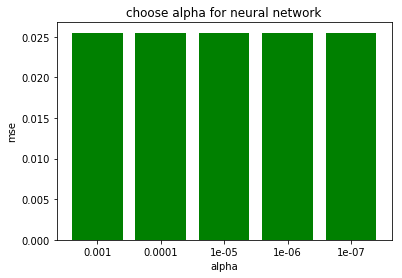

In [217]:
plt.title('choose alpha for neural network')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.bar([str(alpha) for alpha in alpha_range], error_train, color='green')

In [218]:
error_train

[0.02545383758842945,
 0.025451207533478737,
 0.025450779125094414,
 0.02545202150940895,
 0.02551654540002346]

In [186]:
n = 10
d = 2
x = np.random.normal(size=(n,d))
error = np.random.normal(size=(n,1))
b = np.random.uniform(size=(d,1))

### in order to avoid Perfect Separation, we need to add some noise
y = x@b + error

# y = list(map(lambda x: 1 if x > 0 else 0, y))

# binary
# y = np.array([0 if x <0 else 1  for x in y])
# y = np.where(y<0, 0, 1)
## 3 classes
# y = np.array([0 if x < -1 else 1 if x < 1 else 2 for x in y])


In [443]:

class neural:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def complie(self, cost = 'mse', matrix = 'mse'):
        self.cost = cost
        self.matrix = 'mse'
        
    def activation(self, z, function):
        if function == 'linear' : return z
        
        if function == 'sigmod': return 1/(1+ np.exp(-z))

    def deactivation(self, z, function):
        if function == 'linear' : return z
        if function == 'sigmod': 
            f = 1/(1+ np.exp(-z))
            return f*(1-f)  
        
    
    def addBias(self, x):
        ones = np.ones((x.shape[0], 1))
        return np.hstack((ones,x)) 
        
        
    def decost(self, pred, true):
        if self.cost == 'mse':  return pred - true
    
    def dense(self, nodes = [32], pred = 3 , out = 'linear', functions = ['sigmod'], hidden = 2):
        n, d = self.x.shape

        while len(nodes) != hidden:
            nodes.append(nodes[0])
        
        if out == 'linear': 
            nodes = [d] + nodes + [1]
        else:
            nodes = [d] + nodes + [pred]

        while len(functions) != hidden:
            functions.append(functions[0])

        functions = ['input'] + functions+ [out]

        layers = {number+1:[nodes[number], functions[number]] for number in range(hidden+2)}  

        self.layers = layers
        
        return layers

    def make_weights(self):

        layers = self.layers
        layer = len(layers)
        weights = {item:np.random.rand(layers[item][0]+1, layers[item+1][0]+1) for item in range(1, layer-1)}
        weights[layer-1] = np.random.rand(layers[layer-1][0]+1, 1)
        return weights
    
    def forward(self, weights, x = None ):
        if x is None:
            x = self.x
            
        next_input = [self.addBias(x)]
        
        for i in range(1, len(weights)+1):
            next_input.append(next_input[i-1]@weights[i])
        return next_input
    

    def ward(self, x, weight, error, function):
        if function =='input':
            return x.T@error, _
        
        derivate = self.deactivation(x, function)
        return x.T@error, error@weight.T*derivate
    
    def back(self, next_input, weights, y, learning = 0.01):
        number = len(self.layers)
        error ={number:self.decost(next_input[number-1], y)}
        
        update = []
        for layer in range(number-1, 0, -1):
            update, error[layer] = self.ward(next_input[layer-1], weights[layer], error[layer+1], self.layers[layer][1])

            weights[layer] -= update
            
        return weights, np.sum(abs(update))
                               
    def windows(self, batch):
        index = list(range(len(self.x)))
        np.random.shuffle(index)

        return self.x[index[:batch]], self.y[index[:batch]]
    
    
    def fit(self, threshold = 10e-5, batch = 64, epochs = 2):
        
        weights = self.make_weights()
                               
        for epoch in range(epochs):
            
            
            learning = 1/(1+ epoch)
            
            x, y = self.windows(batch)
                               
            next_input = self.forward(weights, x)
            print('epoch {epoch} of {epochs} with mse {mse}'.format(epoch = epoch, epochs = epochs ))
            weights, update = self.back(next_input, weights, y)
            
            self.weights = weights
            
            if update <= threshold:
                return epochs
            
        return epochs
    
    def predict(self, x):
        pred = self.forward(self.weights, x)[-1]
        return pred

# model = neural(x_train.values, y_train.values.reshape(-1,1))
model = neural(x, y )
model.dense()
model.complie(cost = 'mse', matrix = 'mse')
model.fit()

epoch 0 of 2 with mse 
epoch 1 of 2 with mse 


2

In [444]:
model.predict(x)

array([[-6.52920141e+32],
       [ 3.15857836e+32],
       [-6.31118164e+32],
       [ 8.10807729e+32],
       [ 3.03821791e+32],
       [-8.06078300e+32],
       [ 1.75358647e+32],
       [ 2.29133222e+33],
       [ 5.73463504e+32],
       [ 3.09763790e+32]])

In [445]:
y

array([[ 0.18516602],
       [ 0.70102952],
       [-2.35010989],
       [-0.30879426],
       [-0.10433223],
       [ 0.15728613],
       [-1.07966882],
       [-1.09421749],
       [ 2.30699693],
       [-0.37303134]])

In [441]:
model = neural(x_train.values, y_train.values.reshape(-1,1))
model.dense()
model.complie(cost = 'mse', matrix = 'mse')
model.fit()

epoch 0 of 2 with mse 
epoch 1 of 2 with mse 


2

In [442]:
model.predict(x_test)

array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]])